In [2]:
# conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

In [2]:
# conda uninstall pytorch

In [3]:
import numpy as np
import pandas as pd
import tqdm as tq
import anndata as ad
# from scipy.sparse import csr_matrix
# from scipy.sparse import coo_matrix
from anndata.experimental.pytorch import AnnLoader

In [4]:
DATA = "data"
MODELS = "models"

In [47]:
ad_train = ad.read_h5ad(f"{DATA}/ad_train.donor_2.h5ad")

In [48]:
# ad_train.obs["sm_name"].unique()

In [49]:
# ad_train.X = ad_train.X.astype(np.float32)

In [50]:
ad_train.X

<67016x18211 sparse matrix of type '<class 'numpy.float32'>'
	with 107691359 stored elements in Compressed Sparse Row format>

In [51]:
batch_size = 256
shuffle = True

dataloader = AnnLoader(ad_train, batch_size=batch_size, shuffle=shuffle)

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01)
        # BatchNorm layers in the encoder
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)


    def forward(self, x):
        #x = F.relu(self.fc1(x))
        # x = self.leakyrelu(self.fc1(x))
        x = self.leakyrelu(self.bn1(self.fc1(x)))

        # x = F.relu(self.fc2(x))
        # x = self.leakyrelu(self.fc2(x))
        x = self.leakyrelu(self.bn2(self.fc2(x)))

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, output_dim)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01)
        # BatchNorm layers in the encoder
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(512)

    def forward(self, x):
        # x = F.relu(self.fc1(x))
        # x = self.leakyrelu(self.fc1(x))
        x = self.leakyrelu(self.bn1(self.fc1(x)))

        # x = F.relu(self.fc2(x))
        # x = self.leakyrelu(self.fc2(x))
        x = self.leakyrelu(self.bn2(self.fc2(x)))

        x = torch.exp(self.fc3(x))  # Use exp to ensure non-negative outputs for Poisson
        return x

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, mu, logvar

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming you have a dataset (replace this with your actual data)
input_dim = 18211
latent_dim = 64

# Create VAE model
vae_model = VAE(input_dim, latent_dim).to(device)
vae_model= nn.DataParallel(vae_model)
vae_model = vae_model.to(device)

In [54]:
torch.cuda.is_available()

True

In [44]:
# !pip install torchviz

In [45]:
# import torchviz

# # reconstructed_data, mu, logvar = vae_model(batch_data)
# # torchviz.make_dot(vae_model, params=dict(vae_model.named_parameters()))

# encoder_output = vae_model.encoder(torch.randn(1, input_dim).to(device))  # Pass a dummy input to the encoder
# torchviz.make_dot(encoder_output[0], params=dict(vae_model.named_parameters()))

In [ ]:
# Set up optimizer
optimizer = optim.Adam(vae_model.parameters(), lr=0.0005)

# Training parameters
num_epochs = 500

# Save every save_interval epochs
save_interval = 100

beta = 1

# Training loop
loss_all = []
for epoch in range(num_epochs):
    total_loss = 0.0

    for batch_data in tq.tqdm(dataloader):
        batch_data = batch_data.X.to(device)
        bsize, _ = batch_data.shape
        optimizer.zero_grad()

        # print(batch_data.min(), batch_data.max())


        # Forward pass
        reconstructed_data, mu, logvar = vae_model(batch_data)

        # MSE loss and KL divergence
        # recon_loss = F.mse_loss(reconstructed_data, batch_data, reduction='sum')
        recon_loss = F.poisson_nll_loss(reconstructed_data, batch_data, log_input=False, full=False, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #     # kl_divergence /= bsize

        loss = recon_loss + beta * kl_divergence

        # Backward pass
        loss.backward()

        # Gradient Clipping (limiting gradient norms to max_norm=1.0)
        nn.utils.clip_grad_norm_(vae_model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss}')
    loss_all.append(total_loss)

    # Save the model
    if (epoch + 1) % save_interval == 0:
        torch.save(vae_model.state_dict(), f"{MODELS}/model_mse_epoch_{epoch + 1}_donor_2.pt")
        print(f"Model saved at epoch {epoch + 1}")

    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(custom_dataset)}')
    # loss_all.append(total_loss / len(custom_dataset))

100%|██████████| 262/262 [00:09<00:00, 27.53it/s]


Epoch [1/500], Loss: -161532207.6435547


100%|██████████| 262/262 [00:09<00:00, 27.19it/s]


Epoch [2/500], Loss: -237427972.0625


100%|██████████| 262/262 [00:09<00:00, 27.75it/s]


Epoch [3/500], Loss: -240162678.9375


100%|██████████| 262/262 [00:09<00:00, 27.92it/s]


Epoch [4/500], Loss: -241505373.0


100%|██████████| 262/262 [00:09<00:00, 27.13it/s]


Epoch [5/500], Loss: -242748699.6875


100%|██████████| 262/262 [00:09<00:00, 26.35it/s]


Epoch [6/500], Loss: -243484506.0625


100%|██████████| 262/262 [00:09<00:00, 26.64it/s]


Epoch [7/500], Loss: -244334579.0625


100%|██████████| 262/262 [00:09<00:00, 26.53it/s]


Epoch [8/500], Loss: -244922668.25


100%|██████████| 262/262 [00:09<00:00, 27.03it/s]


Epoch [9/500], Loss: -245463057.1875


100%|██████████| 262/262 [00:09<00:00, 27.69it/s]


Epoch [10/500], Loss: -246060558.625


100%|██████████| 262/262 [00:09<00:00, 26.54it/s]


Epoch [11/500], Loss: -246432028.0


100%|██████████| 262/262 [00:09<00:00, 26.38it/s]


Epoch [12/500], Loss: -246873124.1875


100%|██████████| 262/262 [00:09<00:00, 26.85it/s]


Epoch [13/500], Loss: -247094486.25


100%|██████████| 262/262 [00:10<00:00, 25.91it/s]


Epoch [14/500], Loss: -247439412.25


100%|██████████| 262/262 [00:10<00:00, 25.44it/s]


Epoch [15/500], Loss: -247457378.0


100%|██████████| 262/262 [00:09<00:00, 27.80it/s]


Epoch [16/500], Loss: -247998387.25


 35%|███▍      | 91/262 [00:03<00:06, 25.87it/s]

In [30]:
batch_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [31]:
reconstructed_data, mu, logvar = vae_model(batch_data)
# F.poisson_nll_loss(reconstructed_data, batch_data, log_input=False, reduction='sum')

In [32]:
batch_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [33]:
reconstructed_data

tensor([[0.0091, 0.0131, 0.0033,  ..., 0.0821, 0.1847, 0.0858],
        [0.0114, 0.0228, 0.0067,  ..., 0.1167, 0.1191, 0.1473],
        [0.0063, 0.0205, 0.0029,  ..., 0.0792, 0.1100, 0.0837],
        ...,
        [0.0013, 0.0198, 0.0023,  ..., 0.0661, 0.0533, 0.0957],
        [0.0009, 0.0102, 0.0014,  ..., 0.0776, 0.1176, 0.0766],
        [0.0211, 0.0161, 0.0033,  ..., 0.0608, 0.1003, 0.0581]],
       device='cuda:0', grad_fn=<GatherBackward>)

In [34]:
import matplotlib.pyplot as plt

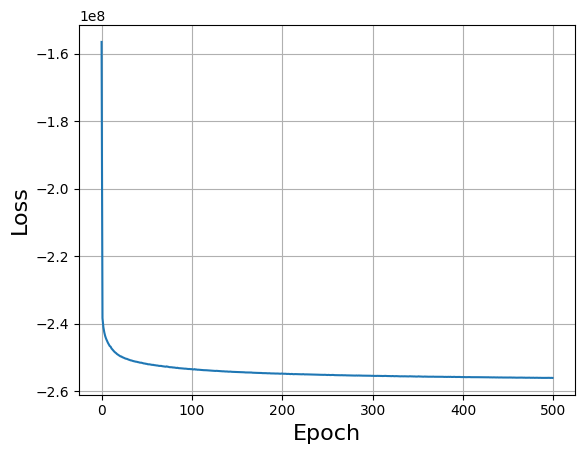

In [35]:
plt.plot(loss_all)
# plt.ylim([10**9, 1.2*10**9])

plt.xlabel("Epoch", size=16)
plt.ylabel("Loss", size=16)
plt.grid()

In [21]:
df_loss = pd.DataFrame({"Epoch":range(num_epochs), "Loss":loss_all})
df_loss["Epoch"] = df_loss["Epoch"]+1

df_loss.to_csv(f"{DATA}/model_loss.tsv", sep="\t", index=None)

# Loading best model

In [12]:
saved_model_path = f"{MODELS}/model_mse_epoch_300.pt"

vae_model.load_state_dict(torch.load(saved_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
import numpy as np
batch_size = 64
#data_loader = DataLoader(customdataset, batch_size=batch_size, shuffle=False)

# Initialize lists to store encoded representations and labels
encoded_representations = []

# Run the encoder on the data
sm_names_all = []
cell_type_all = []
with torch.no_grad():  # Disable gradient computation during inference
    for batch_data in dataloader:
        sm_names_all.append(batch_data.obs["sm_name"])
        cell_type_all.append(batch_data.obs["cell_type"])
        batch_data = batch_data.X.to(torch.float32).to(device)  # Assuming you are using GPU, adjust as needed
        mu, _ = vae_model.encoder(batch_data)
        encoded_representations.append(mu.cpu().numpy())

sm_names_all = np.concatenate(sm_names_all)
cell_type_all = np.concatenate(cell_type_all)

encoded_representations = np.concatenate(encoded_representations, axis=0)

In [13]:
len(sm_names_all), len(cell_type_all)

(32630, 32630)

In [14]:
encoded_representations.shape

(32630, 64)

In [15]:
!pip install --quiet umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [16]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import umap

# Perform UMAP
# umap_result = umap.UMAP(n_components=2).fit_transform(encoded_representations)


In [17]:
umap_model = umap.UMAP(n_components=2)

In [18]:
z_umap = umap_model.fit_transform(encoded_representations)

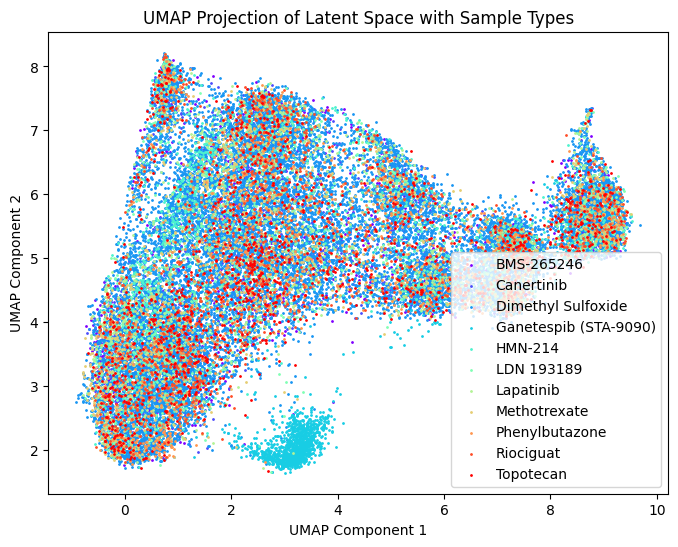

In [19]:
all_sm = sm_names_all
# Get unique sample types and assign colors
unique_types = np.unique(all_sm)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_types)))  # Generate colors based on the number of unique types

# Create a color dictionary for each unique sample type
type_color_dict = {t: c for t, c in zip(unique_types, colors)}

# Map sample types to colors
sample_colors = [type_color_dict[t] for t in all_sm]

# Visualize the UMAP projection with colored points
plt.figure(figsize=(8, 6))
for t, color in zip(unique_types, colors):
    indices = np.where(np.array(all_sm) == t)[0]
    plt.scatter(z_umap[indices, 0], z_umap[indices, 1], label=t, color=color, s=1)

plt.title('UMAP Projection of Latent Space with Sample Types')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()



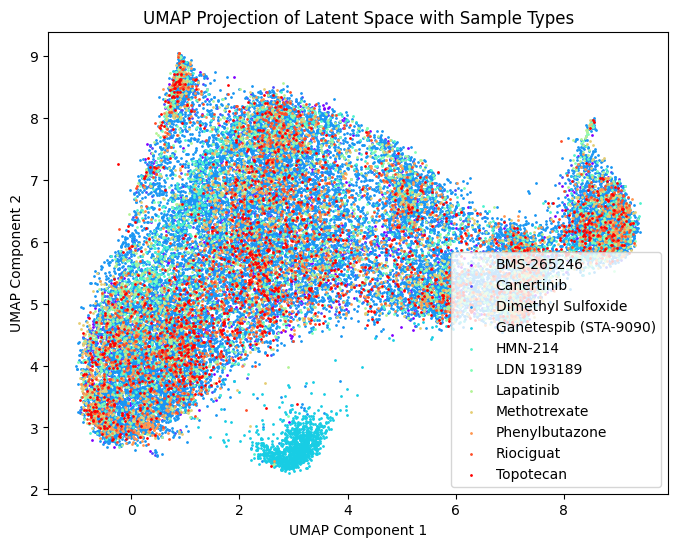

In [65]:
all_sm = sm_names_all
# Get unique sample types and assign colors
unique_types = np.unique(all_sm)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_types)))  # Generate colors based on the number of unique types

# Create a color dictionary for each unique sample type
type_color_dict = {t: c for t, c in zip(unique_types, colors)}

# Map sample types to colors
sample_colors = [type_color_dict[t] for t in all_sm]

# Visualize the UMAP projection with colored points
plt.figure(figsize=(8, 6))
for t, color in zip(unique_types, colors):
    indices = np.where(np.array(all_sm) == t)[0]
    plt.scatter(z_umap[indices, 0], z_umap[indices, 1], label=t, color=color, s=1)

plt.title('UMAP Projection of Latent Space with Sample Types')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()



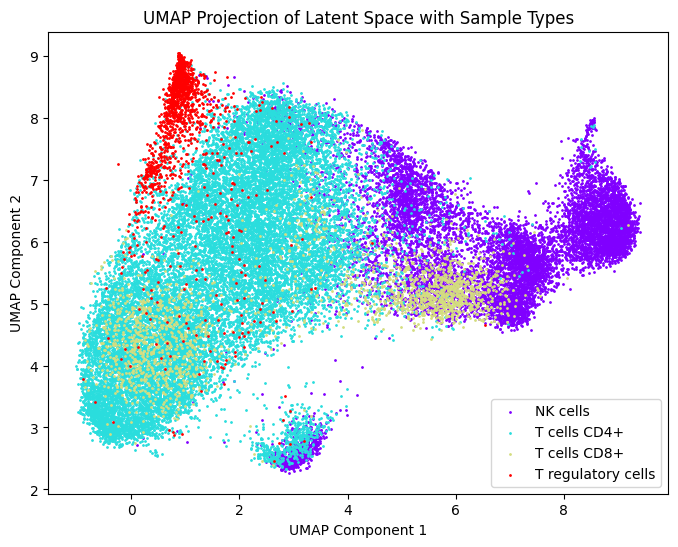

In [66]:

all_sm = cell_type_all
# Get unique sample types and assign colors
unique_types = np.unique(all_sm)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_types)))  # Generate colors based on the number of unique types

# Create a color dictionary for each unique sample type
type_color_dict = {t: c for t, c in zip(unique_types, colors)}

# Map sample types to colors
sample_colors = [type_color_dict[t] for t in all_sm]

# Visualize the UMAP projection with colored points
plt.figure(figsize=(8, 6))
for t, color in zip(unique_types, colors):
    indices = np.where(np.array(all_sm) == t)[0]
    plt.scatter(z_umap[indices, 0], z_umap[indices, 1], label=t, color=color, s=1)

plt.title('UMAP Projection of Latent Space with Sample Types')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()



In [68]:
reconstructed_data, mu, logvar = vae_model(batch_data)

In [69]:
reconstructed_data

tensor([[1.0634e-02, 1.0494e-01, 8.3137e-04,  ..., 7.4709e-01, 4.8620e-01,
         4.0056e-01],
        [3.7953e-03, 5.8509e-04, 1.8502e-03,  ..., 3.0094e-01, 4.6944e-01,
         2.8881e-01],
        [4.7540e-03, 8.8176e-04, 2.9749e-03,  ..., 9.1334e-01, 2.5756e-01,
         6.5235e-01],
        ...,
        [2.0023e-06, 1.7106e-03, 2.6790e-06,  ..., 5.8686e-01, 5.3937e-01,
         8.7261e-01],
        [1.1617e-03, 6.0755e-03, 1.8798e-01,  ..., 1.7747e-01, 3.8220e-01,
         9.9788e-01],
        [3.9732e-02, 1.0550e-03, 5.3030e-01,  ..., 2.3449e-01, 1.6909e+00,
         1.3083e-01]], device='cuda:0', grad_fn=<ExpBackward0>)

In [70]:
batch_data

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 5.2981, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 5.1966, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

# Getting hidden vectors

In [13]:
batch_size = 64
shuffle = True

dataloader = AnnLoader(ad_train, batch_size=batch_size, shuffle=shuffle)

In [14]:
import numpy as np
batch_size = 64
#data_loader = DataLoader(customdataset, batch_size=batch_size, shuffle=False)

# Initialize lists to store encoded representations and labels
encoded_representations = []

# Run the encoder on the data
sm_names_all = []
cell_type_all = []
with torch.no_grad():  # Disable gradient computation during inference
    for batch_data in dataloader:
        sm_names_all.append(batch_data.obs["sm_name"])
        cell_type_all.append(batch_data.obs["cell_type"])
        batch_data = batch_data.X.to(torch.float32).to(device)  # Assuming you are using GPU, adjust as needed
        mu, _ = vae_model.encoder(batch_data)
        encoded_representations.append(mu.cpu().numpy())

sm_names_all = np.concatenate(sm_names_all)
cell_type_all = np.concatenate(cell_type_all)

encoded_representations = np.concatenate(encoded_representations, axis=0)

In [15]:
len(sm_names_all), len(cell_type_all), encoded_representations.shape

(32630, 32630, (32630, 64))

In [36]:
enc_cols = ["mu"+str(i) for i in range(encoded_representations.shape[1])]
df_mu_ = pd.DataFrame(encoded_representations, columns=enc_cols)
df_lab_ = pd.DataFrame({"cell_type":cell_type_all, "sm_names":sm_names_all})
df_mu = pd.concat([df_lab_, df_mu_], axis=1)

In [37]:
# Mean latent vectors for each cell type and perturbation
df_mu_mean = df_mu.groupby(["cell_type", "sm_names"]).median().reset_index()
#df_mu_mean

In [38]:
# calculate perturbations in latent space
df_deltas = df_mu_mean.copy()
for ct in set(cell_type_all):
  to_subtract = df_deltas.loc[(df_deltas.cell_type==ct)&(df_deltas.sm_names=="Dimethyl Sulfoxide"), enc_cols].values
  df_deltas.loc[df_deltas.cell_type==ct, enc_cols] = df_deltas.loc[df_deltas.cell_type==ct, enc_cols].sub(to_subtract)

In [39]:
df_deltas

,cell_type,sm_names,mu0,mu1,mu2,mu3,mu4,mu5,mu6,mu7,...,mu54,mu55,mu56,mu57,mu58,mu59,mu60,mu61,mu62,mu63
0,NK cells,BMS-265246,0.017068,0.382662,-0.255560,0.016724,-0.003361,0.004341,0.001031,-0.005798,...,0.822076,-0.352210,0.003702,0.077860,-0.128834,-0.000151,0.567536,0.009100,-0.003844,-0.009045
1,NK cells,Canertinib,0.000655,0.061461,-0.235184,-0.001042,-0.006546,0.007392,-0.004118,0.000269,...,-0.080281,-0.034546,-0.003005,0.151501,0.030781,-0.002767,0.506090,0.000796,0.004206,0.005734
2,NK cells,Dimethyl Sulfoxide,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,NK cells,Ganetespib (STA-9090),-0.000397,0.534439,-0.594935,-0.011413,0.021421,0.003958,-0.044850,-0.004044,...,0.903543,0.494518,-0.010293,1.310979,0.142217,0.032574,-0.616306,0.021089,0.024077,-0.003512
4,NK cells,HMN-214,0.000457,-0.246755,-0.161293,0.002731,-0.000870,-0.003104,0.010518,-0.002315,...,-0.185676,0.179241,0.001737,0.028550,0.008415,0.001733,0.289446,-0.001862,-0.001636,-0.005167
5,NK cells,LDN 193189,0.006067,-0.147140,0.037645,-0.001358,0.001972,0.001702,0.006053,-0.000565,...,0.289080,0.057727,0.001652,0.085659,-0.212268,-0.001407,-0.189521,0.005705,-0.002094,-0.001911
6,NK cells,Lapatinib,0.002614,0.267554,0.179514,0.004688,-0.001548,-0.000400,-0.001933,0.001277,...,-0.004683,-0.068078,-0.003098,0.194955,0.020463,0.002084,-0.013787,-0.002817,0.001072,0.002552
7,NK cells,Methotrexate,0.002592,0.042577,-0.369022,-0.000984,0.004708,0.005803,0.001444,0.002714,...,-0.006826,0.197559,0.002109,-0.140370,0.005512,-0.001425,-0.045693,0.000377,-0.001367,0.000074
8,NK cells,Phenylbutazone,-0.005115,0.006024,-0.041598,-0.001516,0.000285,0.000114,-0.002600,0.002576,...,-0.009566,-0.191391,-0.001708,-0.148812,-0.018428,0.000509,-0.088291,-0.000830,-0.000686,0.002435
9,NK cells,Riociguat,0.005407,0.049301,0.110394,-0.000843,-0.001266,-0.000589,0.000932,0.001064,...,0.016417,-0.095616,0.002614,0.159138,-0.016212,0.000197,-0.115487,0.006329,0.000840,-0.001649


<Axes: >

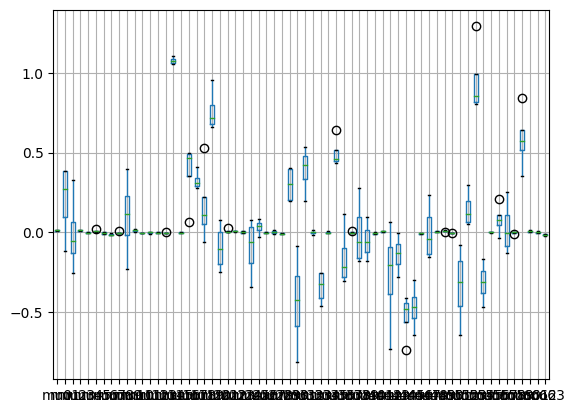

In [44]:
df_deltas.loc[df_deltas.sm_names=="BMS-265246", enc_cols].boxplot()

In [46]:
df_deltas.loc[df_deltas.sm_names=="BMS-265246", enc_cols]

,mu0,mu1,mu2,mu3,mu4,mu5,mu6,mu7,mu8,mu9,...,mu54,mu55,mu56,mu57,mu58,mu59,mu60,mu61,mu62,mu63
0,0.017068,0.382662,-0.255560,0.016724,-0.003361,0.004341,0.001031,-0.005798,-0.006377,0.055124,...,0.822076,-0.352210,0.003702,0.077860,-0.128834,-0.000151,0.567536,0.009100,-0.003844,-0.009045
11,0.011912,0.163882,-0.085453,0.011444,0.000822,0.007409,-0.007585,-0.015440,-0.005805,0.175013,...,0.890940,-0.167562,0.003135,0.074634,-0.067845,-0.000653,0.574017,0.006506,0.005149,-0.014046
22,0.012020,-0.116010,0.327296,0.016390,0.001329,0.005541,0.001507,-0.016776,-0.003876,0.394881,...,1.289820,-0.467683,0.000408,-0.036264,0.062768,0.004899,0.844774,0.002464,-0.003983,-0.019949
33,0.017458,0.384655,-0.019429,0.012118,-0.004401,0.023197,-0.007698,-0.013723,0.006329,-0.228358,...,0.804130,-0.266552,-0.001327,0.212376,0.251819,-0.012865,0.352001,0.012791,0.006526,-0.015328


In [57]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

In [62]:
# Cosine similarities between perturbations for different cell types
df_cossim = pd.DataFrame()
for sm in set(sm_names_all):
  cosine_sim_matrix = cosine_similarity(df_deltas.loc[df_deltas.sm_names==sm, enc_cols])
  np.fill_diagonal(cosine_sim_matrix, np.nan)
  df0 = pd.DataFrame({"sm_names":[sm], "cos_sim":[np.nanmean(cosine_sim_matrix)]})
  df_cossim = pd.concat([df_cossim, df0])
  #print(f"{sm}: {np.nanmean(cosine_sim_matrix)}")
df_cossim

,sm_names,cos_sim
0,HMN-214,0.606782
0,Phenylbutazone,0.342651
0,Lapatinib,0.496822
0,Dimethyl Sulfoxide,0.000000
0,LDN 193189,0.288544
0,Topotecan,0.703371
0,Methotrexate,0.498458
0,Ganetespib (STA-9090),0.527210
0,Canertinib,0.679470
0,Riociguat,0.410272


In [70]:
df_deltas_mean = df_deltas.drop(columns="cell_type").groupby(["sm_names"]).mean().reset_index()
df_deltas_mean

,sm_names,mu0,mu1,mu2,mu3,mu4,mu5,mu6,mu7,mu8,...,mu54,mu55,mu56,mu57,mu58,mu59,mu60,mu61,mu62,mu63
0,BMS-265246,0.014615,0.203797,-0.008286,0.014169,-0.001403,0.010122,-0.003186,-0.012934,-0.002432,...,0.951742,-0.313502,0.001479,0.082152,0.029477,-0.002192,0.584582,0.007715,0.000962,-0.014592
1,Canertinib,0.000312,0.000502,-0.089526,0.000044,-0.002568,0.008926,-0.003049,-0.001575,-0.002233,...,0.067104,0.242073,-0.003475,0.283796,-0.029577,0.001842,0.602670,-0.002358,0.003472,0.003299
2,Dimethyl Sulfoxide,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Ganetespib (STA-9090),0.004191,0.442488,-0.491962,-0.007043,0.008857,-0.002124,-0.016935,-0.009470,-0.007978,...,0.472580,-0.304133,-0.005069,1.135338,-0.190815,0.008531,-0.175977,0.009025,0.014432,-0.015505
4,HMN-214,0.003500,-0.254377,-0.155085,0.001923,-0.002129,-0.003141,0.011125,-0.001005,0.006726,...,-0.075650,0.170691,0.001339,0.102021,-0.036560,-0.001251,0.250240,-0.002829,-0.003835,-0.004226
5,LDN 193189,0.001168,-0.048095,-0.021232,-0.000921,0.003797,0.001910,0.001719,-0.001552,-0.001767,...,0.044426,0.030892,0.000688,0.034158,-0.147211,0.000330,-0.077622,0.005289,-0.000203,-0.000411
6,Lapatinib,-0.001193,0.240175,0.257304,0.004262,0.000782,0.000749,0.000231,-0.005053,-0.000963,...,-0.033351,0.193213,0.001747,0.222928,0.057860,0.007220,0.209047,-0.000342,0.000606,0.002033
7,Methotrexate,0.002337,-0.052126,-0.361813,-0.000419,0.003439,0.000712,0.005424,0.002756,-0.001253,...,0.073039,0.118530,0.000242,-0.082228,0.006529,-0.003191,-0.036505,0.000593,-0.003020,-0.005086
8,Phenylbutazone,-0.000798,-0.029096,0.009136,-0.002951,0.001071,0.000328,-0.000677,0.003335,-0.000668,...,0.049757,-0.251974,-0.002039,-0.123957,0.016053,-0.001278,-0.155063,-0.000010,-0.000584,-0.001097
9,Riociguat,0.003536,0.144167,0.239877,-0.001163,-0.000613,0.001225,-0.003694,-0.001436,-0.001227,...,-0.026230,0.089413,0.001131,0.145230,0.011944,0.003365,-0.088140,0.005825,0.001263,0.000992
